$$
P(X|\theta) =  \prod_{i=1}^{i=N}   \frac{1}{\sigma_{i} \sqrt{2 \pi}} \exp [-\frac{1}{2} (\frac{obs_{i}-pred_{i}(\theta)}{\sigma_{i}} )^{2} ] \\ \\ \\ \\ \\
-log(P(X|\theta)) =  \frac{1}{2}\sum_{n=1}^{\infty} (\frac{obs_{i}-pred_{i}(\theta)}{\sigma_{i}})^{2} \\ \\ \\ \\
$$

$$
Cost = -log(P(X|\theta)) =  \frac{1}{2}\sum_{n=1}^{\infty} (\frac{obs_{i}-pred_{i}(\theta)}{\sigma_{i}})^{2} \\ \\ \\ \\
$$

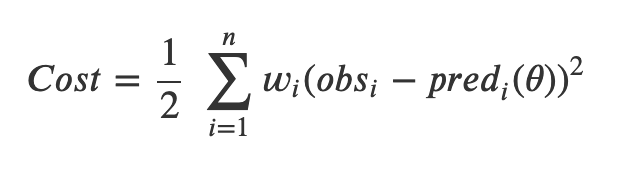

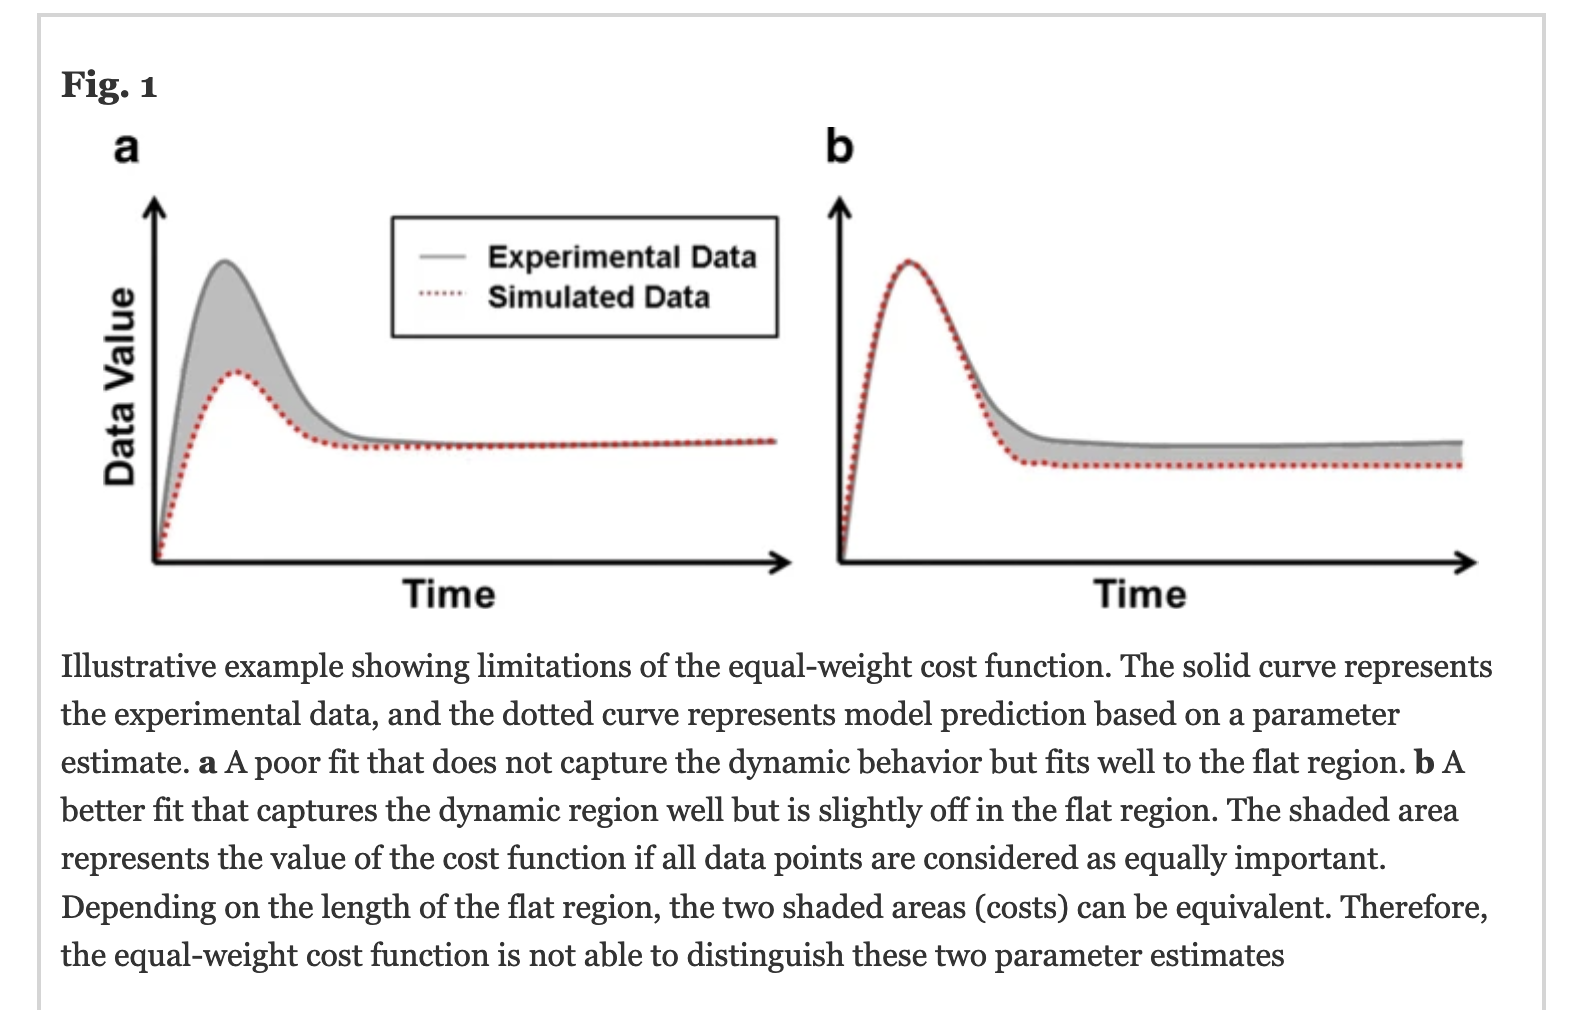

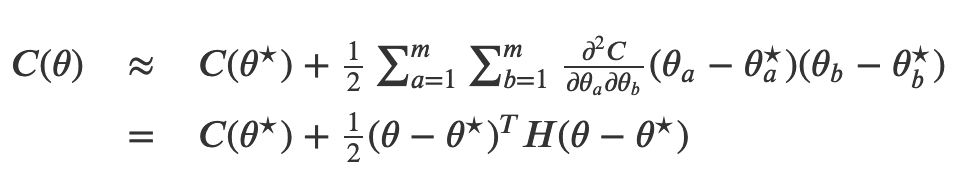

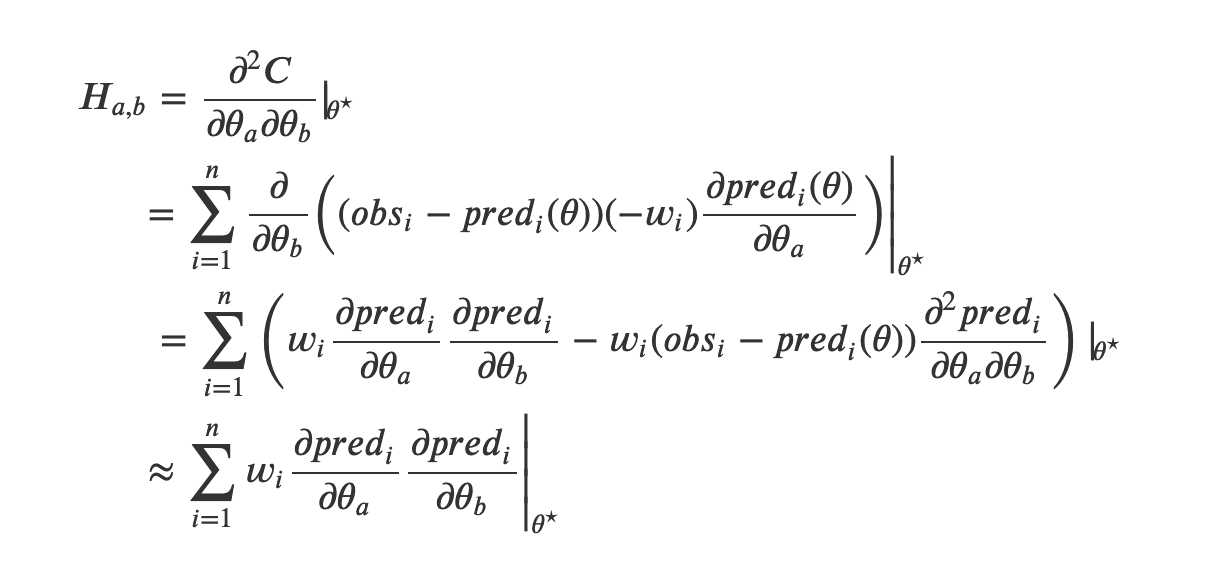

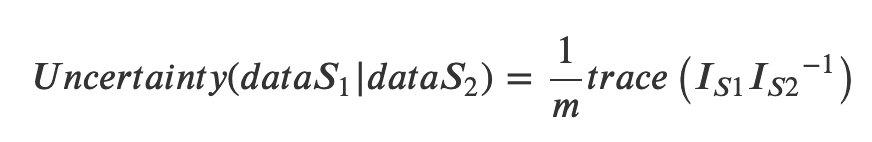

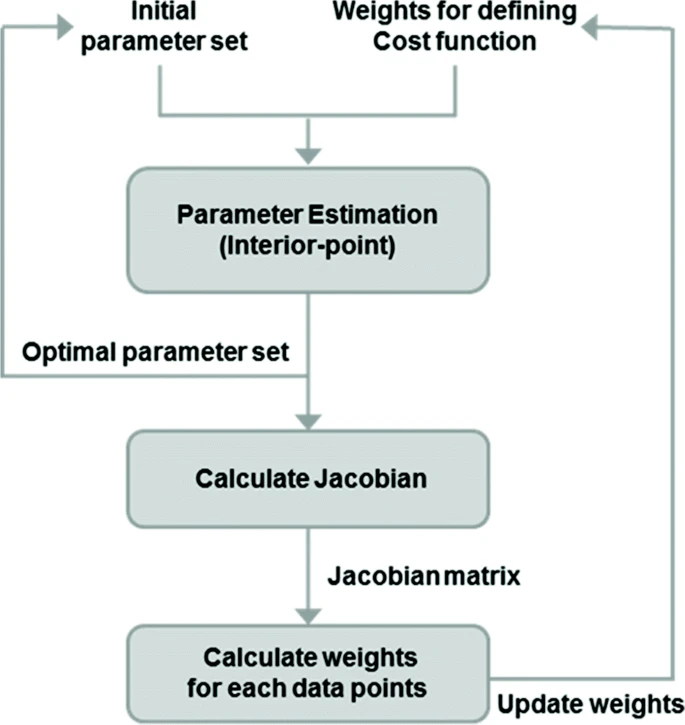

In [ ]:
# %matplotlib notebook

In [1]:
import time

In [2]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
################################################
# from autograd.scipy.integrate import odeint
# from autograd.builtins import tuple
################################################

# from jax.experimental.ode import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [3]:
import jax 
import jax.numpy as jnp
from jax import jacfwd, jacrev

from jax import config
config.update('jax_enable_x64', True)

import numpy as np
# import autograd.numpy as np   # Thinly-wrapped version of Numpy
# from autograd import grad
# from autograd import jacobian

In [4]:
# from jax.experimental.ode import odeint

# def odeint(func, y0, t, *args, rtol=1.4e-8, atol=1.4e-8, mxstep=jnp.inf, hmax=jnp.inf)

In [5]:
from jax import jit

In [6]:
# from multiprocessing import multiprocess

In [7]:
#General plotting functions
#Elimates the left and top lines and ticks in a matplotlib plot 
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)

#Lollipop plot based on the python graph gallery implementation 
def LollipopPlot(Fig,Time,Data,Regression):
    
    cTime=Time
    cData=Data
    cRegression=Regression
    
    ax=Fig.gca()

    (markers, stemlines, baseline) = ax.stem(cTime, cData,bottom=-0.4,label='Data',basefmt=" ")
    plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
    plt.setp(markers, color="red",alpha=0.75 )

    ax.plot(cTime,cRegression,'b-',label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
  
    ax.set_ylabel('Normalized Population',fontsize=16,fontweight='bold')
    ax.set_xlabel('Time',fontsize=16,fontweight='bold')
    ax.legend(loc=0,fontsize=14)
    ax.set_ylim(-0.4,3.4)
    PlotStyle(ax,'')

## Parameter Estimation of Non-Linear ODE system

In [8]:
def RMS_error(y1,y2):
    term1 = np.sum((y1-y2)**2)
    return np.sqrt(term1)

In [9]:
def ODE_RHS_jax(t,lmbda,y):
    
    return jnp.array([lmbda*y])

In [10]:
'''

The parameters of the model are:
lmbda: the rate constant, which is to be estimated
A:     the value at t=0, given

'''

#Parameters of the model 
lmbda = -0.5   #to be estimated
A = 2.0       #NOT to be estimated, this is the value at t=0
num_unknown_parameters = 1 #Number of parameters to be estimated, will be used in ComputeWeights() function later

#Integration time
t_final = 20 #in minutes
num_points = 200 #number of time points to select as data
GlobalSolverTime=np.linspace(0.0,t_final,num_points)
GlobalSolverTime_jax=jnp.linspace(0.0,t_final,num_points)


def ODE_RHS(t, lmbda,A,y):  #NumPy version of the system of ODEs
    #Note that the "A" argument is not being used. I put it here to show you can pass other params this way
    res = np.array([lmbda*y]).flatten()
    return res


#True initial conditions 
InitialConditions=np.array([A])  
InitialConditions_jax=jnp.array([A])  

def ODEModel(y,t,*K):
    lmbda_temp,A_temp = K

    return ODE_RHS(t, lmbda_temp, A_temp, y)

Solution = odeint(ODEModel,InitialConditions,GlobalSolverTime,tuple([lmbda,A]))

In [11]:
Solution.shape

(200, 1)

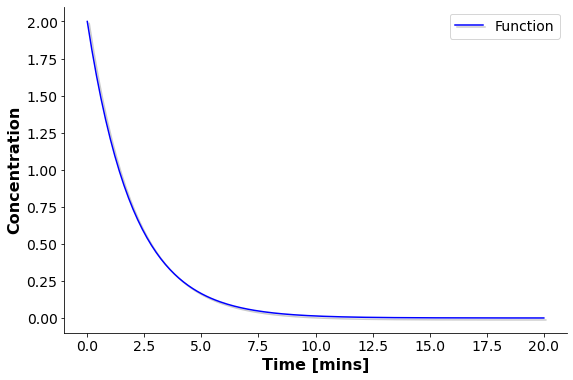

In [12]:
#Visualization
plt.figure(1,figsize=(9,6))

plt.plot(GlobalSolverTime,Solution[:,0],'b-',label='Function',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')


In [13]:
PureSignal = Solution[:,0]

In [14]:
###############################################################################
#                            Noisy Data Generation  
###############################################################################
def MakeNoisyData(Data,Noise):
    return [val+cal for val,cal in zip(Data,Noise)]

# np.random.seed(5)    
np.random.seed(10) #set random num. gen. SEED
# GaussianNoise=[np.random.normal(0,0.10*val) for val in PureSignal]  #add in 10% Gaussian noise
GaussianNoise=[np.random.normal(0,0.10) for val in PureSignal]  #add in fixed 0.1 Gaussian noise
Signal=MakeNoisyData(PureSignal,GaussianNoise)                      #add Gaussian noise

Signal = jnp.asarray(Signal)                                        #measured data




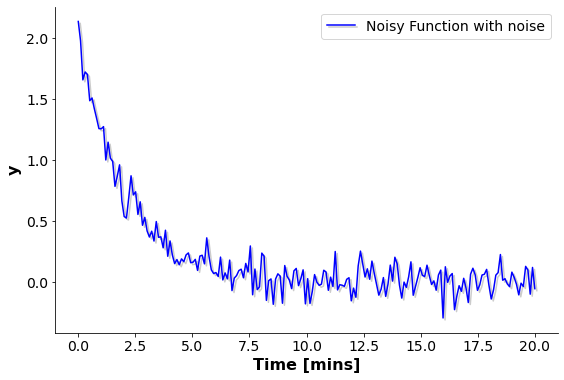

In [15]:
#Visualization
plt.figure(1,figsize=(9,6))

plt.plot(GlobalSolverTime,Signal,'b-',label='Noisy Function with noise',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('y',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')

In [16]:
num_signal_points = len(Signal)

In [17]:
###############################################################################
#                    ODE system model fitting  
###############################################################################
# LATER: Consider the initial parameters as two extra parameters (so 10+2 = 12 parameters in total)
#ModelSolver is the forward solver/integrator

def ModelSolver(t,lmbda_temp,A_temp):
     
    
    Solution=odeint(ODEModel,InitialConditions,t,tuple([lmbda_temp,A_temp]))

    return Solution[:,0].flatten()

def ModelFit(t,lmbda): 
    
    return ModelSolver(t,lmbda,A)

# p0 = np.random.rand(1)
p0 = np.array([1.6]) #initial guess
weights = np.ones(num_signal_points) #Initially, all weights are 1
sigma_now = 1/np.sqrt(weights)


ModelParams01=curve_fit(ModelFit,GlobalSolverTime,Signal,p0,sigma=sigma_now)

In [18]:
# p0 = array([0.45467901, 0.99152412, 0.89004968, 0.48321337]) doesn't throw warning.
#p0 = [0.01590501, 0.2180019 , 4.2508194 , 0.01864846] also doesn't throw warning.

In [19]:
ModelParams01  #True value used is lmbda = -0.5

(array([-0.48906498]), array([[0.00011268]]))

In [20]:
# for idx in range(len(ModelParams01[0])):
#                  print(idx)

In [21]:
fitSolverTime = GlobalSolverTime

#Visualize fit solution
lmbda_fit = ModelParams01[0][0]

Fit = ModelSolver(fitSolverTime,lmbda_fit, InitialConditions)
# prb_fit = Fit[:(int(len(Fit)/2))]
# e2f1_fit= Fit[int((len(Fit)/2)):]

In [22]:
Fit.shape

(200,)

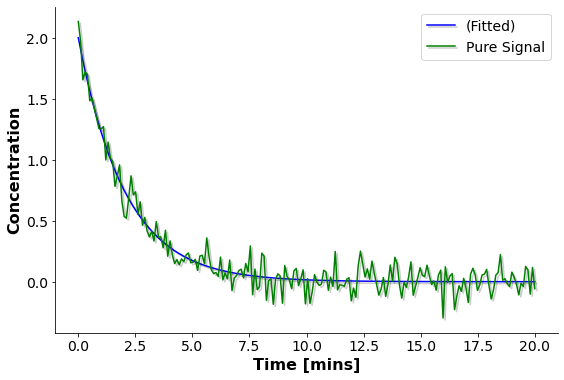

In [23]:
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(fitSolverTime,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(fitSolverTime,Signal,'g-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')


In [24]:
rms_error = RMS_error(Fit,PureSignal) #RMS error 
rms_error 

0.09918940592836682

In [25]:
from jax.experimental.ode import odeint as odeint_jax

In [26]:
#ModelSolver is the forward solver/integrator

def ModelSolver_g(K):
    lmbda_temp = K
    
    def LocalModel(y,t):
        return ODE_RHS_jax(t, lmbda_temp, y)
    
    Solution=odeint_jax(LocalModel,InitialConditions_jax,GlobalSolverTime_jax)
    
    return Solution[:,0].flatten()

In [27]:
# jacobian_func = jacobian(ModelSolver_g,(0)) #Define the jacobian outputting function, AUTOGRAD function
jacobian_fn = jacrev(ModelSolver_g) 

In [28]:
# jacobian_output = jacobian_func(np.array([1.0,0.5,0.5,0.005,0.05,1.6,0.04,4.0,5.0,0.1]))
jacobian_output = jacobian_fn(jnp.array([1.0]))

In [29]:
# jacobian_output = np.asarray(jacobian_output)

In [30]:
# type(jacobian_output)

In [31]:
# jacobian_output.shape  #[num_data_points,num_parameters]

In [32]:
#concatenated data is assumed to have Gaussian noise added
#p0: parameter guesses in first iteration, will change
def ParameterEstimation(current_weights_temp,S2_concatdata,S2_SolverTime, previous_estimates = p0):
    # p0 = np.random.rand(4)
#     weights = np.ones(S2_concatdata) #Initially, all weights are 1
    zero_idx = np.argwhere(current_weights_temp < 1e-25)
    current_weights_temp[zero_idx] = 1e-25
#     current_weights = current_weights/np.sum(current_weights) #do this normalization outside of this function
    current_sigma = 1/np.sqrt(current_weights_temp)
#     print(current_sigma.shape)
#     print(S2_concatdata.shape)
    OptimPar_and_covMatrix=curve_fit(ModelFit,S2_SolverTime,S2_concatdata,previous_estimates,sigma=current_sigma)
    return OptimPar_and_covMatrix #a tuple, parameters estimated from S2 data points

In [33]:
#input index of  data point that we want the weight of
def ComputeWeights(iw):
    # "i" is the index of data points S1
    #JTJ = np.matmul(J.T,J)
    #I = JTJ #approximate total Fisher Information Matrix at optimal parameters. 
    
    #for i in range(data_points):
    i = int(iw[0])
    current_weights = iw[1:]

    S2_data_signal = np.delete(Signal,i)
    S2_SolverTime = np.delete(GlobalSolverTime,i)
    S2_weights = np.delete(current_weights, i)

    ParamEstimates_andCovMatrix = ParameterEstimation(S2_weights,S2_data_signal,S2_SolverTime) 
    
#     print(f'{ParamEstimates_andCovMatrix}')
    
    #Now to compute the Jacobian using the parameters estimated from S2
    
    unknown_parameter_estimates = np.asarray(ParamEstimates_andCovMatrix[0])
#     temp_parameter_array = np.asarray(true_parameter_array)
#     temp_parameter_array[est_par_index] = unknown_parameter_estimates
    
    #this computes Jacobian of ALL points with respect to ALL parameters
    
    jacobian_output = jacobian_fn(unknown_parameter_estimates) 
    jacobian_output = np.asarray(jacobian_output)
#     J = jacobian_output[:,est_par_index]  #this is our J, est_par_index is defined globally
    J = jacobian_output #this is our J, est_par_index is defined globally
#     print(f'{unknown_parameter_estimates}')
#     print(f'{jacobian_output}')

#     print(f'{J}')
    
    #Now to form J^T * W * J
    W = np.diag(current_weights)
    ##############################################################################
#     WJ = np.matmul(W,J) #the "WJ" part in J^T * W * J
#     #this is our J_T*W*J which is the Fisher information matrix approximation
#     #This is also I, the total Fisher Information Matrix approximation, using the estimated pars from S2
#     JTWJ = np.matmul(J.T,WJ)   #I
#     ###############################################################################
    
    #First form I_S1
    S1_row_in_jacobian = J[i,:].reshape(1,num_unknown_parameters) #num_unknown_parameters defined globally
    #W should be diagonal, JTWJ_S1 should have shape [num_unknown_parameters,num_unknown_parameters]
    JTWJ_S1 = W[i,i] * np.matmul(S1_row_in_jacobian.T,S1_row_in_jacobian) 
    I_S1 = JTWJ_S1  
    
    #Now form I_S2
    time_point_indices = np.arange(len(Signal))
    S2_indices = (np.setdiff1d(time_point_indices,i)).astype(int)
#     print(type(S2_indices))
    #If num of S2 points was 1, you'd need to reshape this. But it probably isn't 1, UNLESS you have two time data points
    S2_rows_in_jacobian = J[S2_indices,:] 
    W_forS2 = np.diag(current_weights[S2_indices])
#     print(f'{J}')
    print(f"#########  i = {i} #########")
    print(f'{W_forS2}')
    print("######################")
#     print(f'{S2_rows_in_jacobian}')
    
    try:
        WJ_S2 = np.matmul(W_forS2,S2_rows_in_jacobian)
        I_S2 = np.matmul(S2_rows_in_jacobian.T,WJ_S2)
    except:
        print(f'{WJ_S2}')
        print(f'{J}')
        print(f'{S2_rows_in_jacobian}')
    
    
    
        
    
    
#     I_S1_I_S2 = np.matmul(I_S1,I_S2)
    
#     identity_matrix = np.identity(I_S1_I_S2.shape[0])
#     I_S1_I_S2_inv = np.linalg.solve(I_S1_I_S2,identity_matrix)
    identity_matrix = np.identity(I_S2.shape[0])
    try:
        I_S2_inv = np.linalg.solve(I_S2,identity_matrix)
    except:
        print(" ")
        print(f'{i}')
        print(f'{I_S2}')
        print(f'{S2_indices}')
    
#     uncertainty_of_S1_given_S2 = (1.0/num_unknown_parameters) * np.trace(I_S1_I_S2_inv)
    uncertainty_of_S1_given_S2 = (1.0/num_unknown_parameters) * np.trace(np.matmul(I_S1,I_S2_inv))
    
    new_S1_weight = uncertainty_of_S1_given_S2
    
    return new_S1_weight

In [34]:
initial_weights = np.ones([len(Signal),len(Signal)])

initial_weights.shape

i_array = np.arange(len(Signal)).reshape(len(Signal),1) #the "index" array

i_array.shape

arr = np.hstack((i_array,initial_weights))

arr.shape

(200, 201)

In [35]:
p0

array([1.6])

In [36]:
p0.size

1

In [37]:
iterations = 20
num_params_to_estimate = p0.size
i_array = np.arange(len(Signal)).reshape(len(Signal),1) #array of indices of the data points

#create array to hold the weights of the data points over the iterations
weights_array = np.ones([iterations+1,len(Signal)]) #the first row will be not be normalized (doesn't matter)
#create array to hold the history of estimated parameters over the iterations
estimated_parameters_array = np.ones((iterations+1,num_params_to_estimate)) 
estimated_parameters_array[0,:] = p0.copy()  #the first iteration will use p0 from before

In [38]:
p0 

array([1.6])

In [ ]:
np.save("NoisyData_Seed20_FixedZeroPointOneNoise_10Points_Gaussian.npy",Signal)

In [ ]:
arr

In [ ]:
# np.set_printoptions(precision=40)
# arr_iteration 

In [ ]:
################################ Iterative process ###################################
start = time.time()
# p0 will be changed here
arr_iteration = arr
start = time.time()
for i in np.arange(iterations):
    result1 = np.ones(len(Signal))
    for j in range(len(arr_iteration[:,0])):
        result1[j] = ComputeWeights(arr_iteration[j,:])
        
    
     
    result1 = result1/np.sum(result1) #normalize the weights
    
    weights_array[i+1,:] = result1.copy() #store in weights array 
    
    
    #Use weights to compute new candidate parameter set (as of now this is NOT confirmed to be the best one)
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    
    #Need to update p0 this way for the calls to ParameterEstimation from "ComputeWeights" to work correctly
    for idx in range(len(new_parameters_and_CovMatrix[0])):
        p0[idx] = new_parameters_and_CovMatrix[0][idx]
    #Now with the new weights, run parameter fitting to get the best parameter set
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    estimated_parameters_array[i+1,:] = new_parameters_and_CovMatrix[0] #store in est. parameter history array
    
    np.save("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy",weights_array)
    np.save("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy",estimated_parameters_array)

    
    arr_iteration = np.repeat(result1.reshape(1,len(result1)),len(Signal),axis=0) #Signal and result1 should have the same length
    
    arr_iteration = np.hstack((i_array,arr_iteration))

    
end = time.time() 

print(end-start)

In [ ]:
arr_iteration

In [ ]:
weights_array[7,:]

In [ ]:
result1

In [ ]:
#7263.5/60 #121.1 mins for 20 iterations, floor = 1e-20, random seed=10, fixed 0.2 gaussian noise

In [ ]:
7232/60

In [ ]:
7180.7/60

In [ ]:
weights_array[29:30,18:20]

In [ ]:
#7236/60 = 120.6 mins taken for 20 iterations, 10% Gaussian noise, random seed = 5

In [ ]:
#7120.273985147476/60  =119 mins taken for 20 iterations, random seed = 5

In [ ]:
# 7157.896894931793/60 #119.3 mins for 20 iterations

In [ ]:
# 704.9233162403107/60 #took 12 mins

In [ ]:
np.argwhere(weights_array<0)

In [ ]:
weights_array.shape

In [ ]:
weights_array

In [ ]:
plt.plot(GlobalSolverTime, np.log(weights_array[20,:]))

In [ ]:
np.argwhere(weights_array[20,:]==np.max(weights_array[20,:]))

In [ ]:
weights_array[20,19]

In [ ]:
# np.argwhere(weights_array[20,:]==np.min(weights_array[20,:]))

In [ ]:
weights_array[20,56]

In [ ]:
plt.plot(GlobalSolverTime, (weights_array[20,:]))

In [ ]:
plt.plot(np.arange(21),np.log(weights_array[:,190]))

In [ ]:
plt.scatter(np.arange(21),np.log(weights_array[:,19]))

In [ ]:
estimated_parameters_array

In [ ]:
def nsmall(a, n):
    return np.partition(a, n)[n]

In [ ]:
nsmall(weights_array[-1,:],199)

In [ ]:
np.argwhere(weights_array[-1,:]==nsmall(weights_array[-1,:],199))

In [ ]:
20*20/200

In [ ]:
np.min(weights_array[20,:])

In [ ]:
fitSolverTime = GlobalSolverTime

#Visualize fit solution
lmbda_fit = estimated_parameters_array[-1]

Fit = ModelSolver(fitSolverTime,lmbda_fit, InitialConditions)
# prb_fit = Fit[:(int(len(Fit)/2))]
# e2f1_fit= Fit[int((len(Fit)/2)):]

#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(fitSolverTime,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(fitSolverTime,Signal,'g-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==np.max(weights_array[20,:]))],color='r',label="most weight")
plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==nsmall(weights_array[-1,:],num_points-2))],color='b',label="2nd most weight")
# plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==np.min(weights_array[20,:]))], color='y',label="least weight")
# plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==nsmall(weights_array[-1,:],1))],color='m',label="2nd least weight")

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')


In [ ]:
weights_array

In [ ]:
rms_error = RMS_error(Fit,PureSignal) #RMS error 
rms_error 

In [ ]:
np.argwhere(abs(Signal - PureSignal) == np.max(abs(Signal - PureSignal)))

In [ ]:
def exp_func(lmbda_temp,t=GlobalSolverTime):
    return np.exp(lmbda_temp*t)

In [ ]:
np.argmax(PureSignal-Signal)

In [ ]:
# plt.plot(exp_funcv(1.4,GlobalSolverTime))

In [ ]:
exp_func(-0.5).shape

In [ ]:
# plt.plot(GlobalSolverTime,np.apply_along_axis(exp_func,0, GlobalSolverTime,np.ones(200)))

In [ ]:
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((Signal-temp)**2)  
# Loss_v = np.vectorize(Loss)

In [ ]:
Loss(-0.5)

In [ ]:
num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((Signal-temp)**2)) 
    

In [ ]:
np.argwhere(loss_store_array == np.min(loss_store_array))

In [ ]:
lambda_array[np.argwhere(loss_store_array == np.min(loss_store_array))]

In [ ]:
%matplotlib notebook

In [ ]:
plt.plot(lambda_array,np.log(loss_store_array))

In [ ]:
np.argwhere(loss_store_array == np.min(loss_store_array)) #index of min lambda

In [ ]:
lambda_array[326] #minimum lambda

In [ ]:
# plt.plot(np.linspace(-0.6,0.6,200),np.log(loss),s=0.8)

In [ ]:
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(new_weights,(Signal-temp)**2))) 
    

In [ ]:
plt.plot(np.arange(200),new_weights[-1,:])

In [ ]:
plt.plot(lambda_array,weighted_loss_store_array)

In [ ]:
# plt.plot(fitSolverTime[:5],Fit[:5],'b-',label='(Fitted) P_b+P_int+P_intern',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
#                        path_effects.Normal()])
# plt.plot(fitSolverTime[:5],PureSignal[:5],'g-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
#                        path_effects.Normal()])

In [ ]:
# estimated_parameters_array

In [ ]:
ld_weights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")

In [ ]:
plt.plot(GlobalSolverTime,ld_weights[5,:])

# Plots

Define some functions

In [39]:
# def exp_func(lmbda_temp,t=GlobalSolverTime):
#     return np.exp(lmbda_temp*t)
# def Loss(lmbda_temp):
#     temp = A*exp_func(lmbda_temp)
#     return np.sum((Signal-temp)**2)  

# num_lambda_points = 1000
# lambda_array = np.linspace(-0.75,0,num_lambda_points)
# loss_store_array = np.zeros(num_lambda_points)
# for index,item in enumerate(lambda_array):
#     temp = A*exp_func(item)
#     loss_store_array[index] = (np.sum((Signal-temp)**2)) 

In [40]:
def RMS_error(y1,y2):
    term1 = np.sum((y1-y2)**2)
    return np.sqrt(term1)

### 5% gaussian noise

In [41]:
#20 Iterations
#Random seed
#5% gaussian noise
#200 points between t=0 and t=20
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved (mistake: future runs saved the noisy data as well), hence could not plot the loss
function.
"""

weights1 = np.load("FirstRun_SimpleExpModel_weights_20_iterations.npy")
params1 = np.load("FirstRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations.npy")

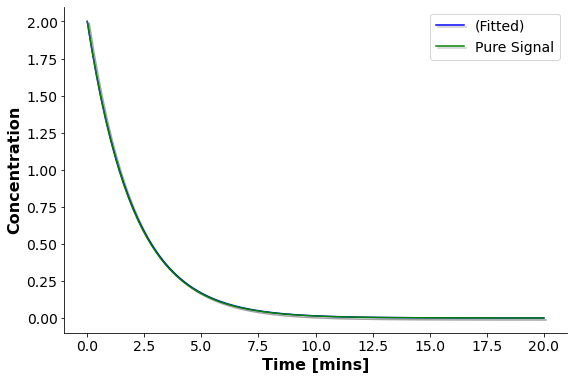

In [42]:
Plot_Time = np.linspace(0,20,200)
Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,Solution,'g-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

In [43]:
Fit.shape

(200,)

In [44]:
Solution.shape

(200,)

Text(0, 0.5, '[Concentration]')

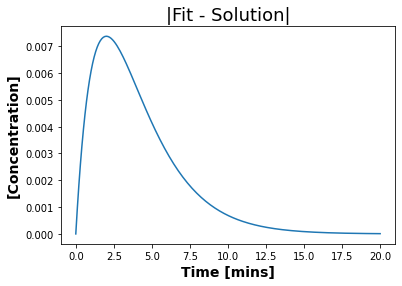

In [45]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')

In [46]:
rms_error = RMS_error(Fit,Solution) #RMS error 
rms_error 

0.04481533759512022

In [47]:
#Index where the maximum difference between the fit and pure signal occurs
max_diff_idx = np.argwhere(abs(Difference) == np.max(abs(Difference))) 
max_diff_idx

array([[20]])

In [48]:
#Time where the maximum difference between the fit and pure signal occurs
Plot_Time[max_diff_idx].flatten()[0]

2.0100502512562817

In [49]:
# Now plot weights

In [50]:
weights1[1,:].shape

(200,)

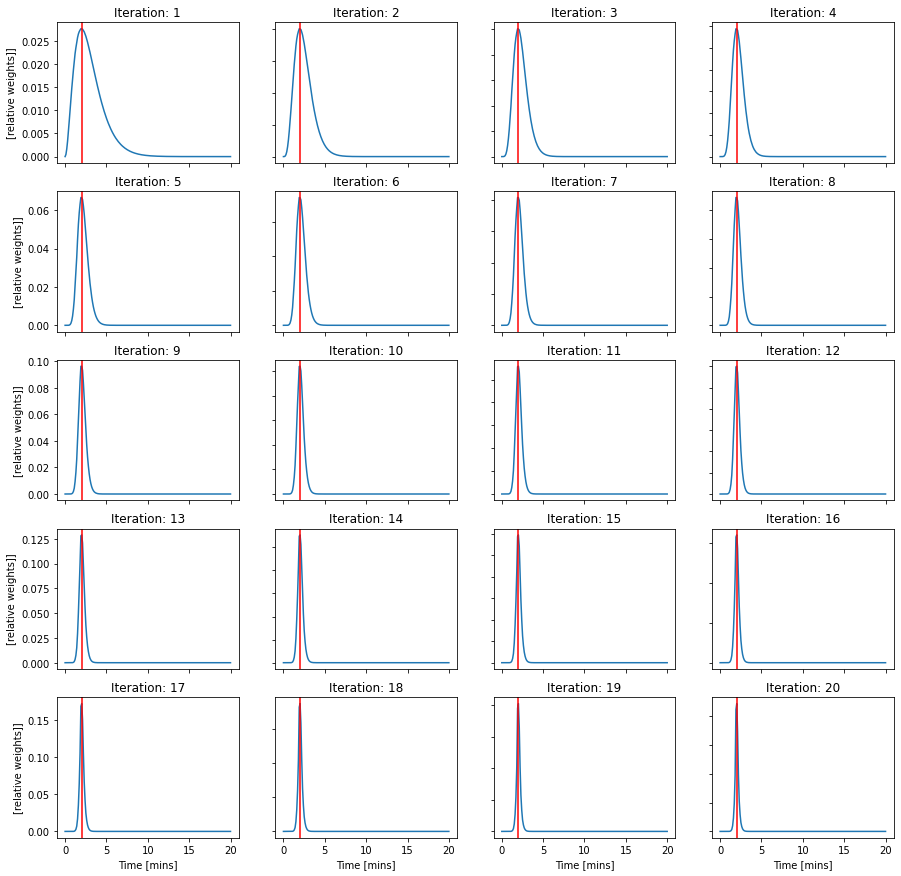

In [51]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,weights1[int(4*i + j+1),:])
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='[relative weights]]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

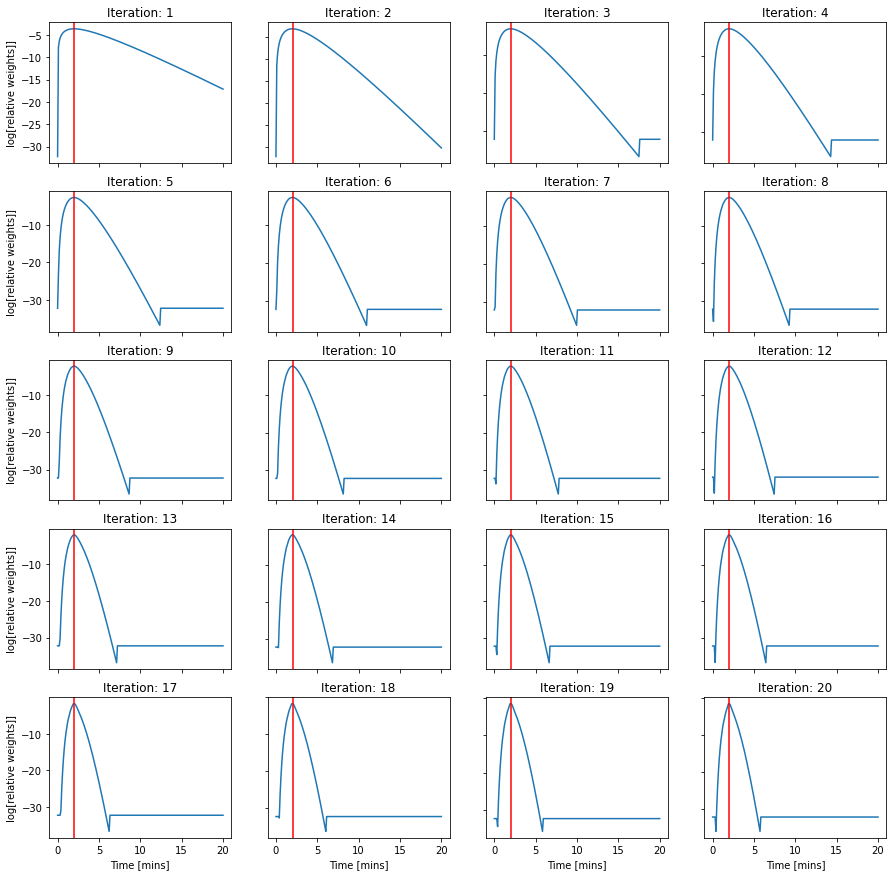

In [52]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log[relative weights]]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

<strong>Conclusion: Weights converge to the 20th data point:  $t\approx2$ mins<strong>

Text(0.5, 1.0, 'ln (weights)')

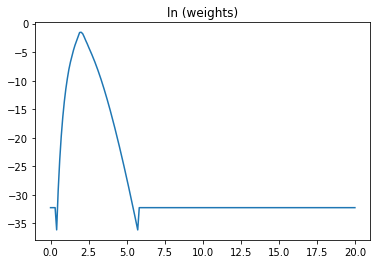

In [53]:
plt.plot(Plot_Time,np.log(weights1[-1,:]))
plt.title("ln (weights)")

### 5% gaussian noise (2)

In [54]:
#20 Iterations
#Random seed = 5
#5% gaussian noise
#200 points between t=0 and t=20
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed5_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed5.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed5.npy")

In [55]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 

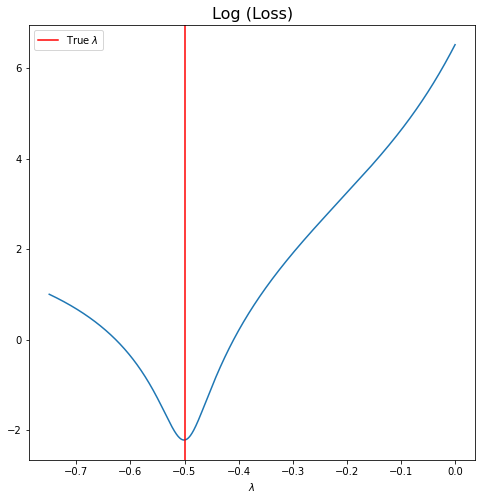

In [56]:
fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,np.log(loss_store_array))
plt.title("Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

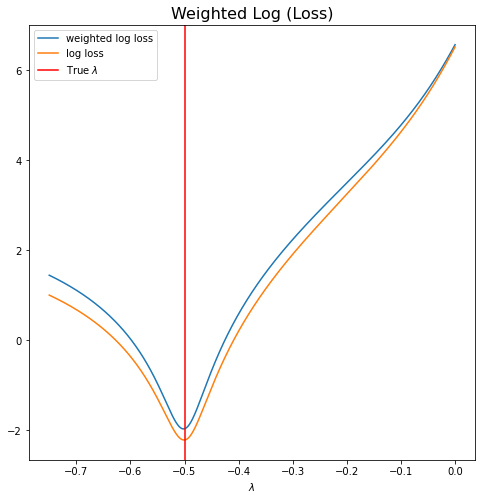

In [57]:
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

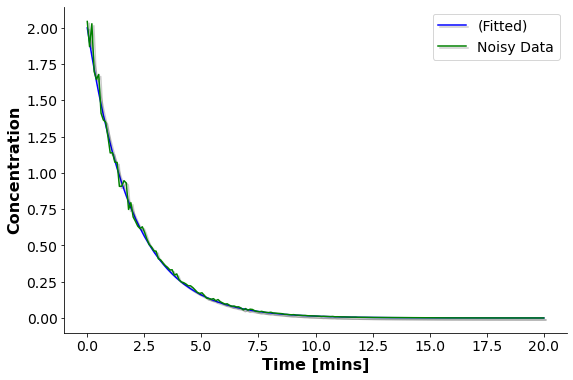

In [58]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

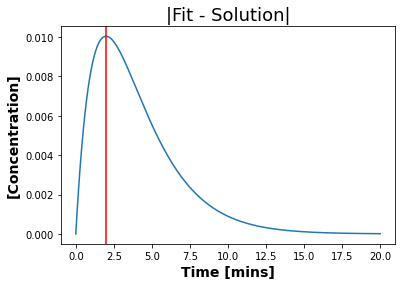

In [59]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [60]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

True

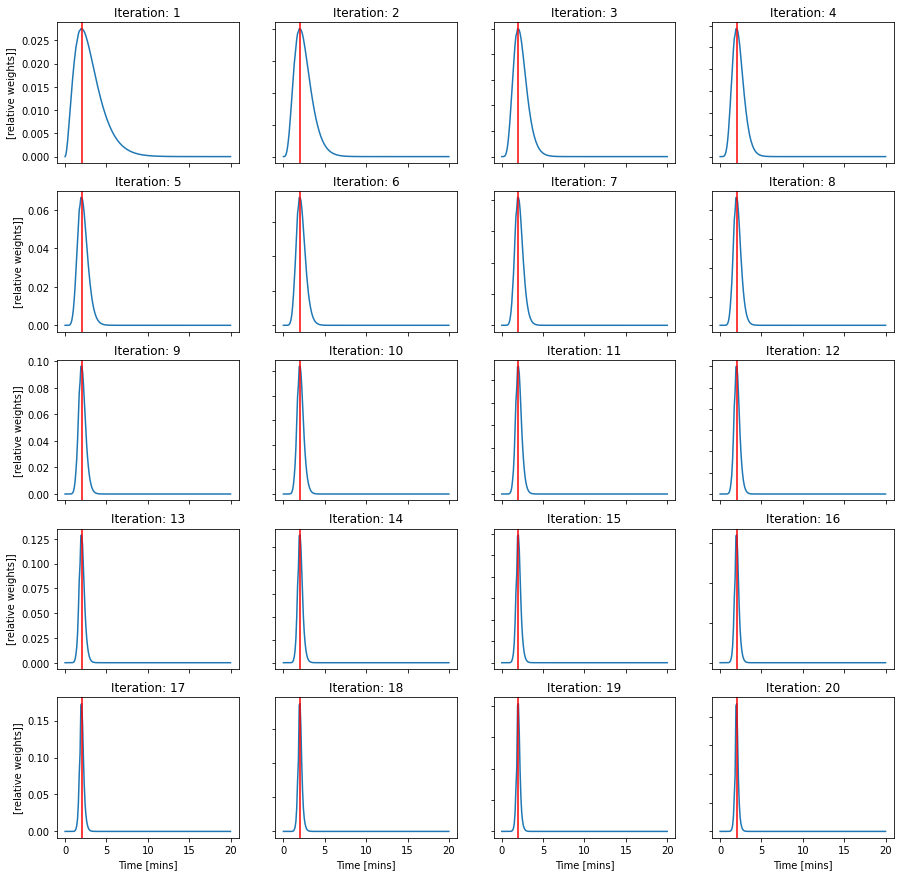

In [61]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,weights1[int(4*i + j+1),:])
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='[relative weights]]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

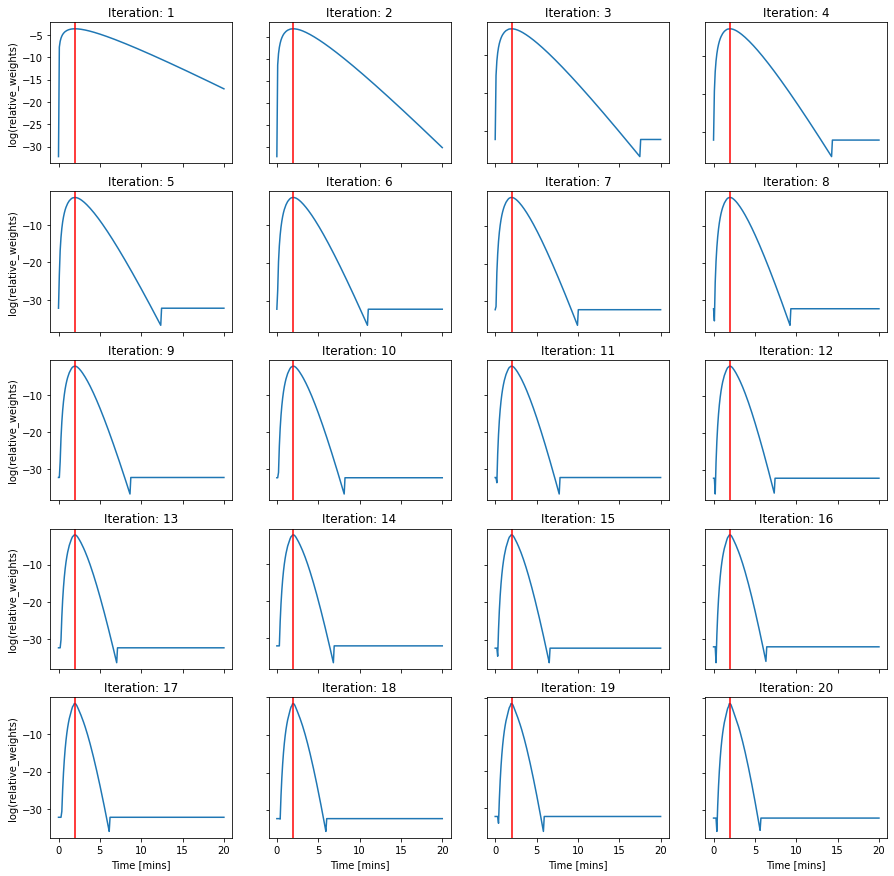

In [62]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

### 10% Gaussian 

In [63]:
#20 Iterations
#Random seed = 5
#10% gaussian noise
#200 points between t=0 and t=20
#Here the max weight was given to data point with index [19] (instead of [20] as above)
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed5_10Percent_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed5_10PercentGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed5_10PercentGaussian.npy")

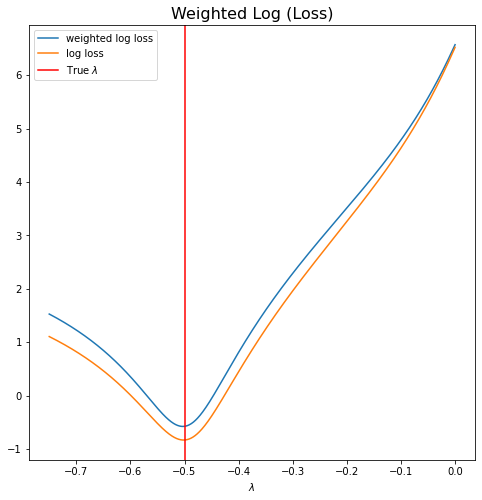

In [64]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

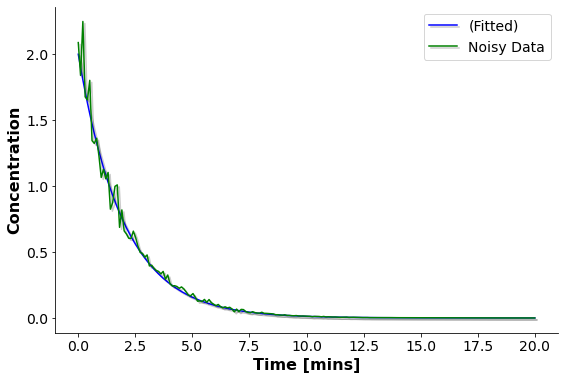

In [65]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

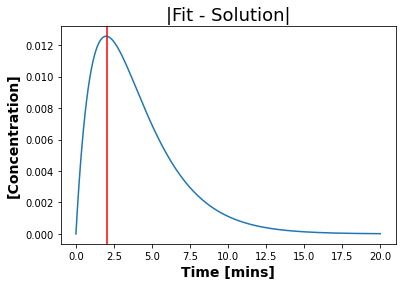

In [66]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [67]:
Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]] #Time point 19 has highest weight

1.9095477386934674

In [68]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

False

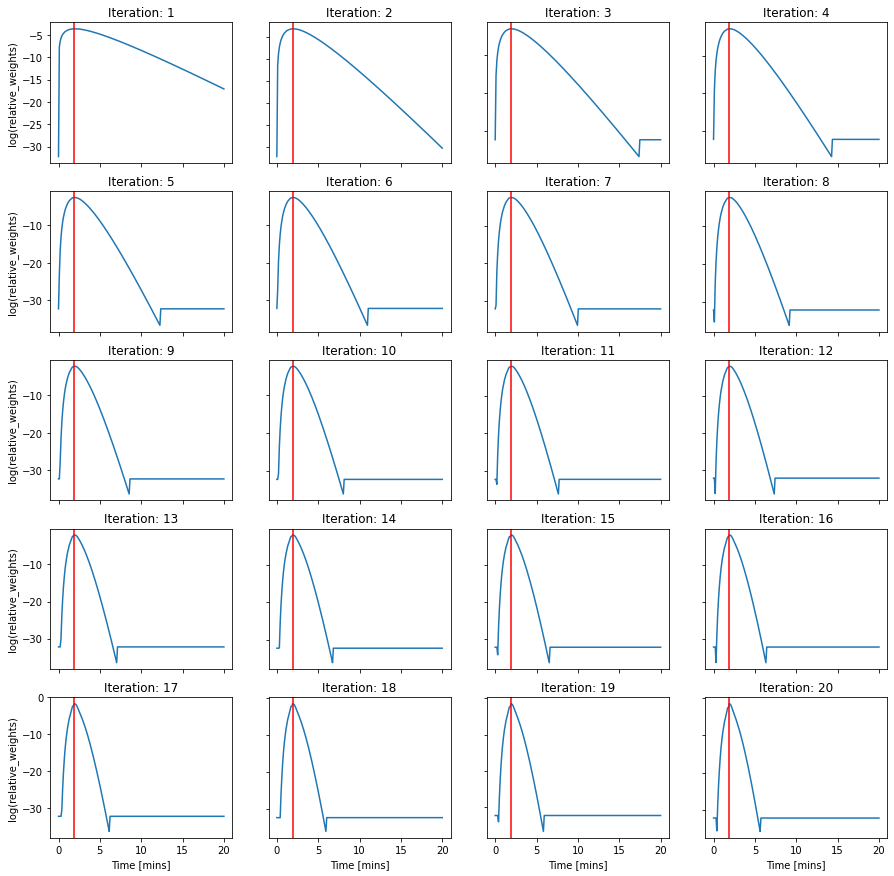

In [69]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [70]:
#Here the max weight was given to data point with index [19] 

### Fixed Gaussian noise (sigma=0.1)

In [71]:
#20 Iterations
#Random seed = 5
#Fixed gaussian noise with sigma = 0.1
#200 points between t=0 and t=20
#Here too, max weight was given to data point with index [19]
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed5_FixedZeroPointOneNoise_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed5_FixedZeroPointOneGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed5_FixedZeroPointOneGaussian.npy")

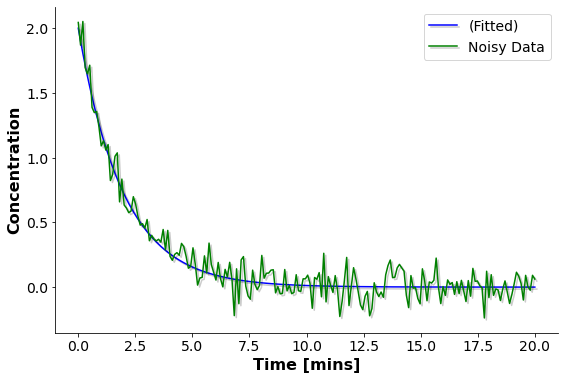

In [72]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

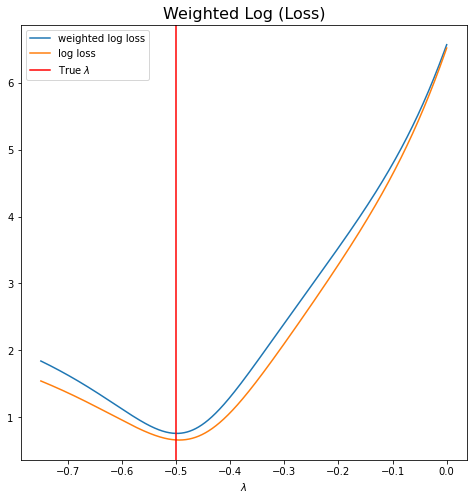

In [73]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [74]:
np.argwhere(weighted_loss_store_array == np.min(weighted_loss_store_array))

array([[334]])

In [75]:
lambda_array[334]- (-0.5)

0.0007507507507507616

In [76]:
np.argwhere(loss_store_array == np.min(loss_store_array))

array([[340]])

In [77]:
lambda_array[340] - (-0.5) #weighting seemed to have moved the min point a bit farther from the truth

0.005255255255255276

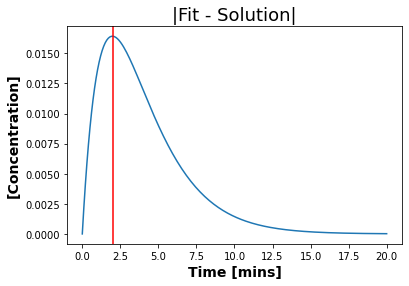

In [78]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [79]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

False

In [80]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

19

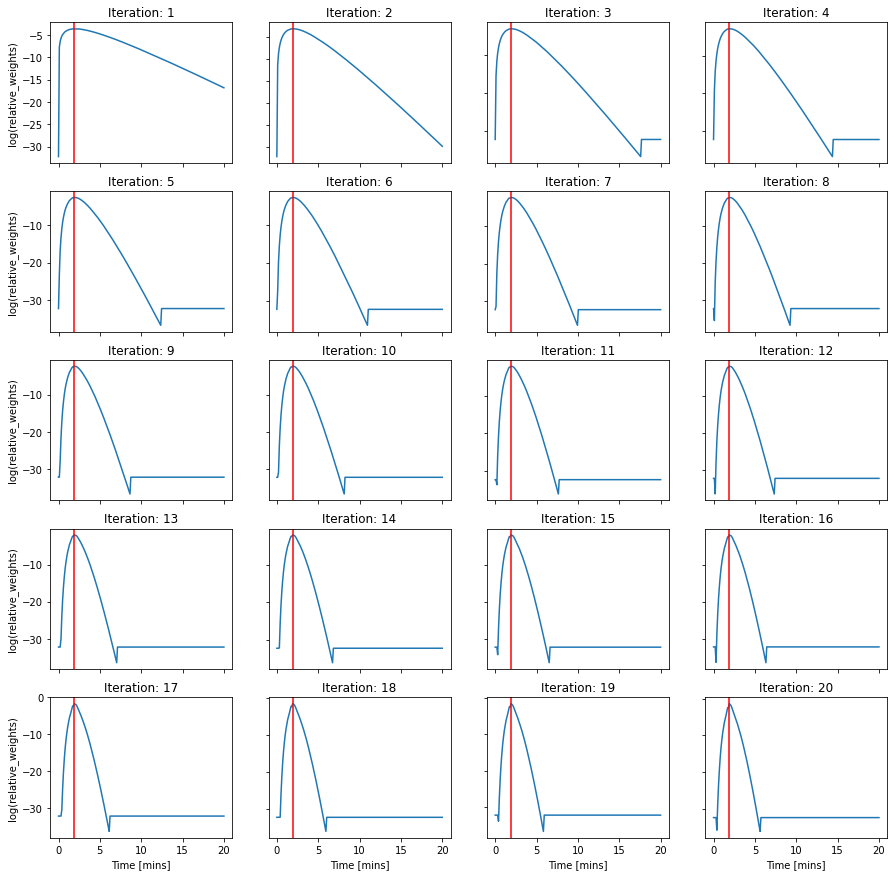

In [81]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [82]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

19

### Fixed Gaussian noise (sigma=0.1, 29 iterations)

In [83]:
#29 Iterations
#Random seed = 10
#Fixed gaussian noise with sigma = 0.1
#200 points between t=0 and t=20
#Using updated weights moves min point in loss function to the true minimum , lambda = -0.5
#max difference between fit and true signal is at data point index [18]
"""
Notes:

For this one, noise coded in correctly (assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed10_FixedZeroPointOneNoise_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_29_iterations_RandomSeed10_FixedZeroPointOneGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_29_iterations_RandomSeed10_FixedZeroPointOneGaussian.npy")

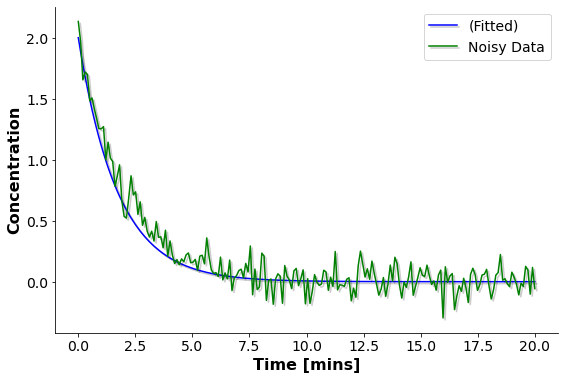

In [84]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

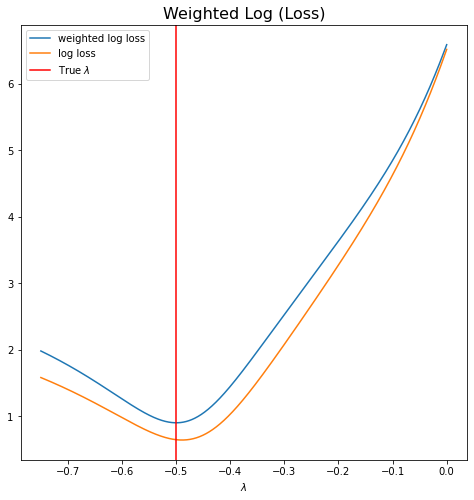

In [85]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [86]:
np.argwhere(weighted_loss_store_array == np.min(weighted_loss_store_array))

array([[333]])

In [87]:
lambda_array[333]-(-0.5)

0.0

In [88]:
np.argwhere(loss_store_array == np.min(loss_store_array)) #Weighting has not moved the minimum point

array([[348]])

In [89]:
lambda_array[348]-(-0.5)  # >0, weighting has therefore moved the minimum point to the true minimum

0.011261261261261257

In [90]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

21

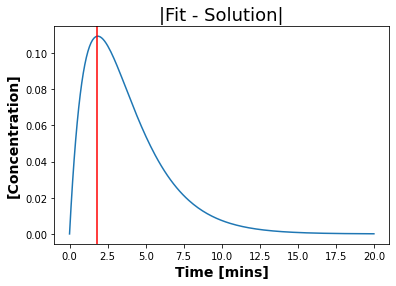

In [91]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [92]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

False

In [93]:
np.argwhere(abs(Difference)==np.max(abs(Difference))) #max difference between fit and true signal is still data point [18]

array([[18]])

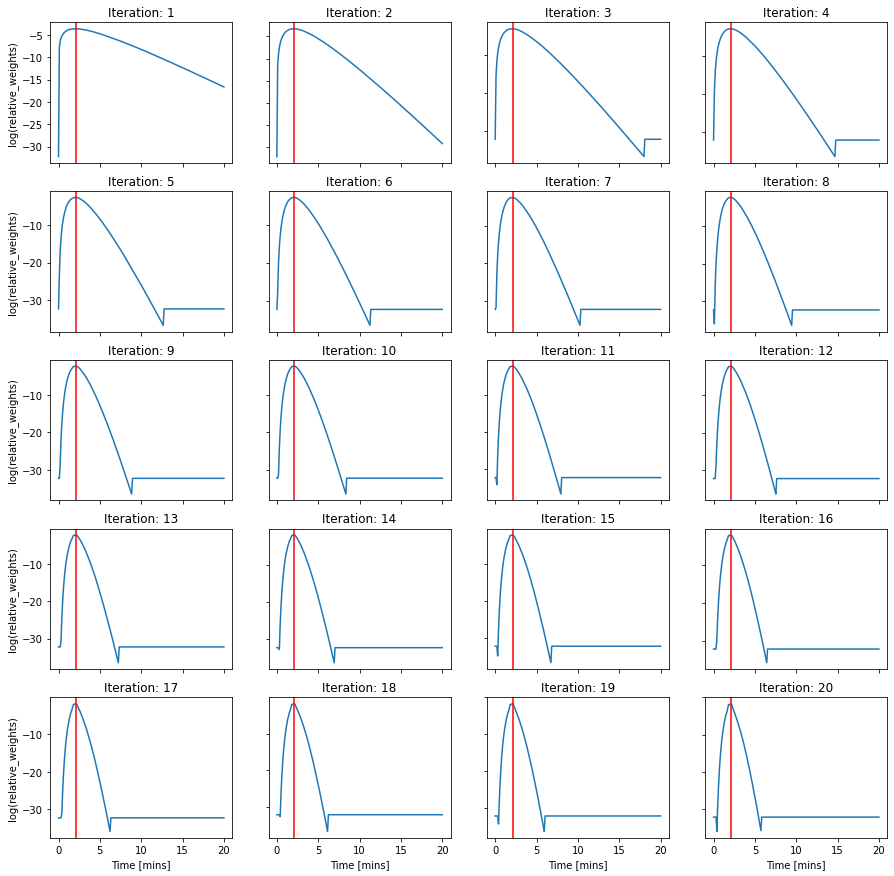

In [94]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

### Fixed Gaussian noise (sigma=0.2)

In [95]:
#20 Iterations
#Random seed = 10
#Fixed gaussian noise with sigma = 0.1
#200 points between t=0 and t=20
#Here, the data point with index [22] was the max (t of about 2.2 min)
"""
Notes:

For this one, noise coded in correctly (assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed10_FixedZeroPointTwoNoise_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed10_FixedZeroPointTwoGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed10_FixedZeroPointTwoGaussian.npy")

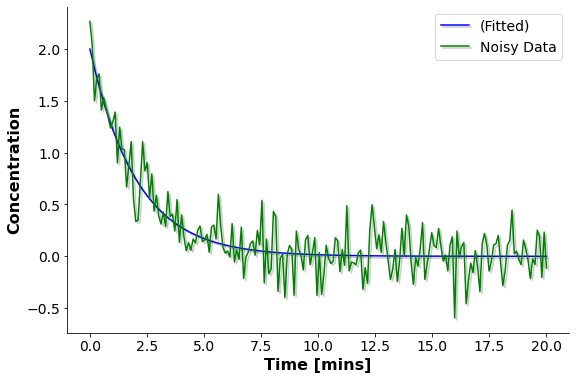

In [96]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

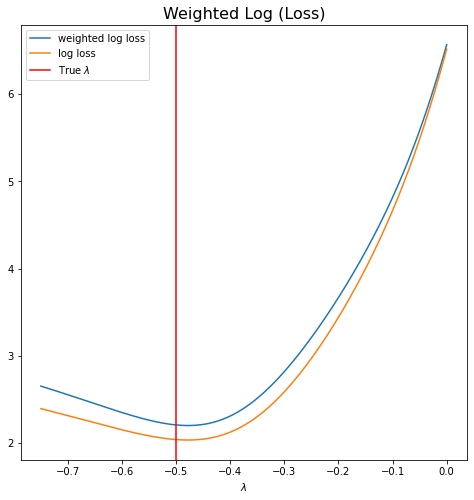

In [97]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [98]:
np.argwhere(weighted_loss_store_array == np.min(weighted_loss_store_array))

array([[362]])

In [99]:
lambda_array[362]-(-0.5)

0.021771771771771753

In [100]:
np.argwhere(loss_store_array == np.min(loss_store_array)) #Weighting has not moved the minimum point

array([[362]])

In [101]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

22

In [102]:
Plot_Time[22] #this is the point with the highest weight in the last iteration

2.21105527638191

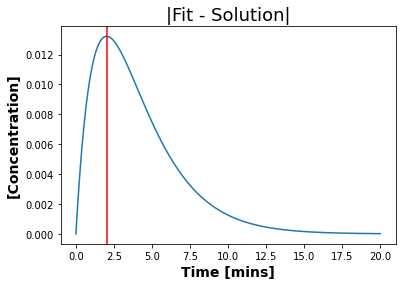

In [103]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [104]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

False

In [105]:
np.argwhere(abs(Difference)==np.max(abs(Difference))) #max difference between fit and true signal is still data point [20]

array([[20]])

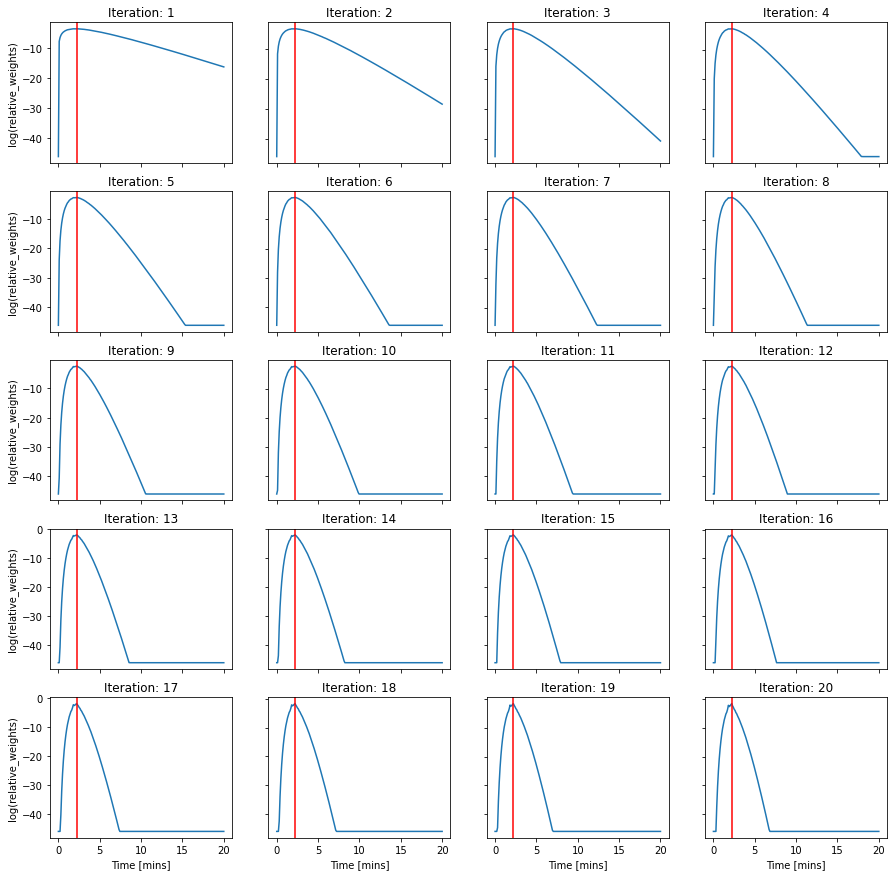

In [106]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

## Fisher Information calculated analytically

In [107]:
from scipy.integrate import quad

In [108]:
# A=2
sigma = 0.1
# lmbda_true = -0.5

def I_OneSample(lmbda_temp,x_temp,w_temp):
    """
    This function computes the "Fisher Information" at a given lambda for ONE observed sample.
    Requires "A" and "sigma" to be defined globally or outside the function in their scope.
    Inputs:
        1. lmbda_temp: the "true" value of the estimated parameter "lambda" //in our case we use estimated lambdas
        2. x_temp:     a single observed data point 
        3. w_temp:     weight of the observed data point (CHECK)
    """
    if abs(w_temp)<1e-50:
        w_temp = 1e-50
    sigma_temp = sigma/w_temp
    def integrand(y_i,lmbda_temp2,x_temp2):
        outer_term = (A/sigma_temp**2)*(1/(sigma_temp*np.sqrt(2*np.pi)))
        term1= 2*A*(x_temp2**2)*np.exp(-2*lmbda_temp2*x_temp2)*np.exp((-1/2)*((y_i-A*np.exp(-lmbda_temp2*x_temp2))/sigma_temp)**2)
        term2= -1*((x_temp2**2)*y_i*np.exp(-1*lmbda_temp2*x_temp2)*np.exp((-1/2)*((y_i-A*np.exp(-lmbda_temp2*x_temp2))/sigma_temp)**2))
        return outer_term*(term1+term2)
    
    I1 = quad(integrand, -np.inf, np.inf, args=(lmbda_temp,x_temp))
    return I1[0]

# def I_OneSample(lmbda_temp,x_temp,max_iter=1000):
#     """
#     This function computes the "Fisher Information" at a given lambda for ONE observed sample.
#     Requires "A" and "sigma" to be defined globally or outside the function in their scope.
#     Inputs:
#         1. lmbda_temp: the "true" value of the estimated parameter "lambda" //in our case we use estimated lambdas
#         2. x_temp:     a single observed data point along the x-axis
#         3. max_iter: (DEFAULT=1000) the number of times integration bounds will be expanded.
#     """
#     iter_count = 0
#     upper_b = 200
#     lower_b = -upper_b
#     I1 = 0             #initialize starting value to 0
#     I2 = 0             #initialize starting value to 0
    
#     def integrand(y_i,lmbda_temp2,x_temp2):
#         outer_term = (A/sigma**2)*(1/(sigma*np.sqrt(2*np.pi)))
#         term1= 2*A*(x_temp2**2)*np.exp(-2*lmbda_temp2*x_temp2)*np.exp((-1/2)*((y_i-A*np.exp(-lmbda_temp2*x_temp2))/sigma)**2)
#         term2= -1*((x_temp2**2)*y_i*np.exp(-1*lmbda_temp2*x_temp2)*np.exp((-1/2)*((y_i-A*np.exp(-lmbda_temp2*x_temp2))/sigma)**2))
#         return outer_term*(term1+term2)
    
#     I2 = quad(integrand, lower_b, upper_b, args=(lmbda_temp,x_temp))[0]
#     while abs(I2-I1) > 1e-10:
#         I1 = I2
#         I2 = quad(integrand, lower_b-50, upper_b+50, args=(lmbda_temp,x_temp))[0]
#         iter_count = iter_count + 1
#         if iter_count > max_iter:
#             print("Error in I_OneSample: integrand not converging fast enough or more iterations needed.")
#             break
            
#     return I2

def I(lmbda,x_array,w_array):
    num_points = len(x_array.flatten())
    arr = np.zeros(num_points)
    for i in range(num_points):
        arr[i] = I_OneSample(lmbda,x_array[i],w_array[i])
    return np.sum(arr)

In [109]:
I(-0.5,np.array([3]),np.array([1]))

72307.9329234759

In [110]:
#input index of  data point that we want the weight of
import math
def ComputeWeights_analyticFisher(iw):
    # "i" is the index of data points S1 
    #for i in range(data_points):
    i = int(iw[0])
    x_i = GlobalSolverTime[i]
    current_weights = iw[1:]

    S2_data_signal = np.delete(Signal,i)
    S2_SolverTime = np.delete(GlobalSolverTime,i)
    S2_weights = np.delete(current_weights, i)
#     print(S2_weights.shape)
    ParamEstimates_andCovMatrix = ParameterEstimation(S2_weights,S2_data_signal,S2_SolverTime) 
      
    unknown_parameter_estimates = np.asarray(ParamEstimates_andCovMatrix[0])
#     print(unknown_parameter_estimates.shape)    

    I_S1 = I(unknown_parameter_estimates,np.array([x_i]),np.array([current_weights[i]])) #CHECK
#     print(I_S1)
    
    I_S2 = I(unknown_parameter_estimates,S2_SolverTime,S2_weights)
#     print(I_S2)
    
    new_S1_weight = I_S1/I_S2
    if math.isnan(new_S1_weight):
        new_S1_weight = 0.0
    return new_S1_weight

In [111]:
initial_weights = np.ones([len(Signal),len(Signal)])

initial_weights.shape

i_array = np.arange(len(Signal)).reshape(len(Signal),1) #the "index" array

print(i_array.shape)

arr = np.hstack((i_array,initial_weights))

print(arr.shape)

(200, 1)
(200, 201)


In [112]:
arr[0:].flatten().shape

(40200,)

In [ ]:
ComputeWeights_analyticFisher(arr[7,:])

In [ ]:
p0

In [ ]:
iterations = 20
num_params_to_estimate = p0.size
i_array = np.arange(len(Signal)).reshape(len(Signal),1) #array of indices of the data points

#create array to hold the weights of the data points over the iterations
weights_array = np.ones([iterations+1,len(Signal)]) #the first row will be not be normalized (doesn't matter)
#create array to hold the history of estimated parameters over the iterations
estimated_parameters_array = np.ones((iterations+1,num_params_to_estimate)) 
estimated_parameters_array[0,:] = p0.copy()  #the first iteration will use p0 from before

In [ ]:
import time

In [ ]:
################################ Iterative process ###################################
start = time.time()
# p0 will be changed here
arr_iteration = arr
start = time.time()
for i in np.arange(iterations):
    result1 = np.ones(len(Signal))
    for j in range(len(arr_iteration[:,0])):
        result1[j] = ComputeWeights_analyticFisher(arr_iteration[j,:])
        
    
     
    result1 = result1/np.sum(result1) #normalize the weights
    
    weights_array[i+1,:] = result1.copy() #store in weights array 
    
    
    #Use weights to compute new candidate parameter set (as of now this is NOT confirmed to be the best one)
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    
    #Need to update p0 this way for the calls to ParameterEstimation from "ComputeWeights" to work correctly
    for idx in range(len(new_parameters_and_CovMatrix[0])):
        p0[idx] = new_parameters_and_CovMatrix[0][idx]
    #Now with the new weights, run parameter fitting to get the best parameter set
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    estimated_parameters_array[i+1,:] = new_parameters_and_CovMatrix[0] #store in est. parameter history array
    
    np.save("SecondRun_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed20_200Points_FixedZeroPointOneGaussian.npy",weights_array)
    np.save("SecondRun_AnalyticalFisher_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed20_200Points_FixedZeroPointOneGaussian.npy",estimated_parameters_array)

    
    arr_iteration = np.repeat(result1.reshape(1,len(result1)),len(Signal),axis=0) #Signal and result1 should have the same length
    
    arr_iteration = np.hstack((i_array,arr_iteration))

    
end = time.time() 

print(end-start)

In [ ]:
plt.plot(GlobalSolverTime,np.log(weights_array[20,:]))

### Random seed = 20, sigma = 0.1, 10 points

In [ ]:
an_weights = np.load("SecondRun_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")
nu_weights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")

In [ ]:
t = np.linspace(0.0,2.0,10)

In [ ]:
an_weights # sets time at t=2 mins to infinity, and the rest to equally important, after which the "nan" causes 
           #the rest to be "nan" too

In [ ]:
nu_weights[9,:] #after 9 iterations converges to t=2 mins being the most important (the rest are close to 0)

In [ ]:
plt.plot(t,np.log(nu_weights[9,:]))

In [ ]:
# PreviousWeights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")
# PreviousWeights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")

In [ ]:
# PreviousWeights[9,:] #previous, data point 2 was deemed the most important

In [ ]:
# plt.plot(GlobalSolverTime,np.log(PreviousWeights[-1,:]))

### Random Seed=10, sigma=0.1, 200 points ###

In [113]:
initial_weights = np.ones([len(Signal),len(Signal)])

initial_weights.shape

i_array = np.arange(len(Signal)).reshape(len(Signal),1) #the "index" array

print(i_array.shape)

arr = np.hstack((i_array,initial_weights))

print(arr.shape)

(200, 1)
(200, 201)


In [ ]:
p0

In [ ]:
iterations = 20
num_params_to_estimate = p0.size
i_array = np.arange(len(Signal)).reshape(len(Signal),1) #array of indices of the data points

#create array to hold the weights of the data points over the iterations
weights_array = np.ones([iterations+1,len(Signal)]) #the first row will be not be normalized (doesn't matter)
#create array to hold the history of estimated parameters over the iterations
estimated_parameters_array = np.ones((iterations+1,num_params_to_estimate)) 
estimated_parameters_array[0,:] = p0.copy()  #the first iteration will use p0 from before

In [ ]:
################################ Iterative process ###################################
start = time.time()
# p0 will be changed here
arr_iteration = arr
start = time.time()
for i in np.arange(iterations):
    result1 = np.ones(len(Signal))
    for j in range(len(arr_iteration[:,0])):
        result1[j] = ComputeWeights_analyticFisher(arr_iteration[j,:])
        
    
     
    result1 = result1/np.sum(result1) #normalize the weights
    
    weights_array[i+1,:] = result1.copy() #store in weights array 
    
    
    #Use weights to compute new candidate parameter set (as of now this is NOT confirmed to be the best one)
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    
    #Need to update p0 this way for the calls to ParameterEstimation from "ComputeWeights" to work correctly
    for idx in range(len(new_parameters_and_CovMatrix[0])):
        p0[idx] = new_parameters_and_CovMatrix[0][idx]
    #Now with the new weights, run parameter fitting to get the best parameter set
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    estimated_parameters_array[i+1,:] = new_parameters_and_CovMatrix[0] #store in est. parameter history array
    
    np.save("SecondRun_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy",weights_array)
    np.save("SecondRun_AnalyticalFisher_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy",estimated_parameters_array)

    
    arr_iteration = np.repeat(result1.reshape(1,len(result1)),len(Signal),axis=0) #Signal and result1 should have the same length
    
    arr_iteration = np.hstack((i_array,arr_iteration))

    
end = time.time() 

print(end-start)

In [ ]:
#2320/60 #took 39 mins for analytic computation

In [114]:
Plot_Time = np.linspace(0.0,20.0,200)
# plt.plot(Plot_Time,np.log(weights_array[-1,:]))

In [115]:
an_weights = np.load("SecondRun_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy")
nu_weights = np.load("SecondRun_SimpleExpModel_weights_29_iterations_RandomSeed10_FixedZeroPointOneGaussian.npy")

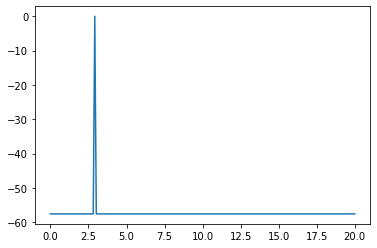

In [116]:
plt.plot(Plot_Time,np.log(an_weights[-1,:]))

In [117]:
np.argwhere(an_weights[-1,:] == np.max(an_weights[-1,:]))

array([[29]])

In [118]:
np.argwhere(nu_weights[-1,:] == np.max(nu_weights[-1,:]))

array([[21]])

In [120]:
Plot_Time[29]

2.9145728643216082

In [121]:
Plot_Time[21]

2.1105527638190957

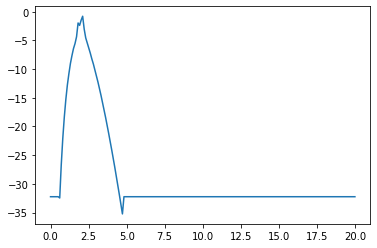

In [122]:
plt.plot(Plot_Time,np.log(nu_weights[-1,:]))

In [123]:
#Plot anlaytically computed weights

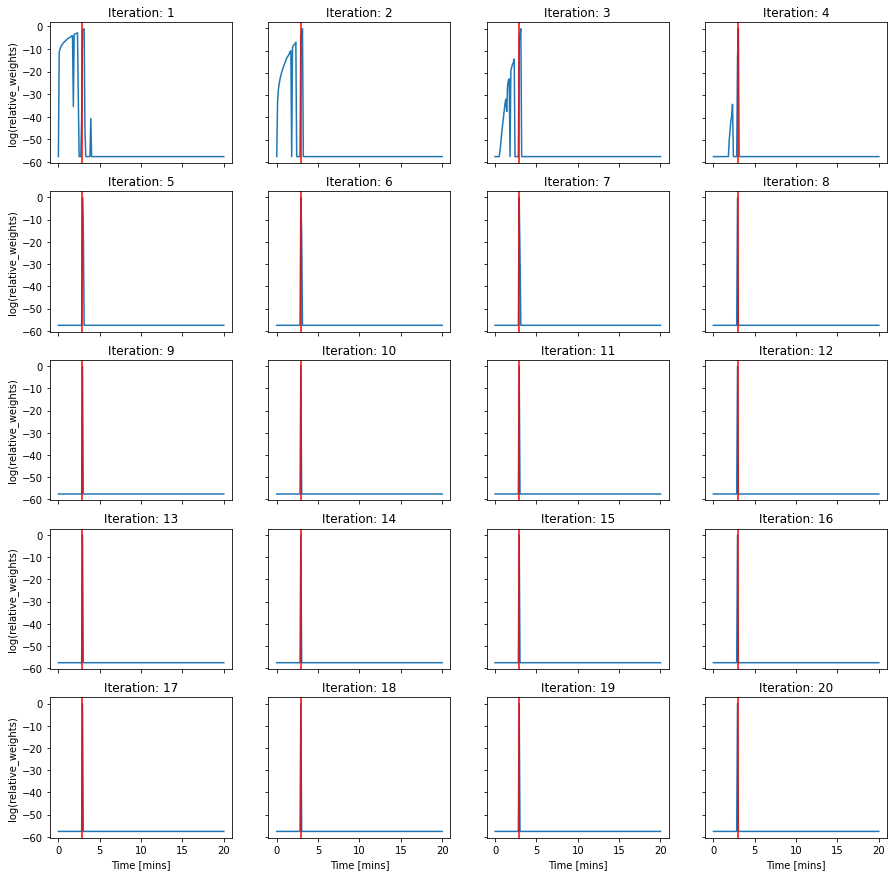

In [124]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(an_weights[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(an_weights[-1,:]==np.max(an_weights[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

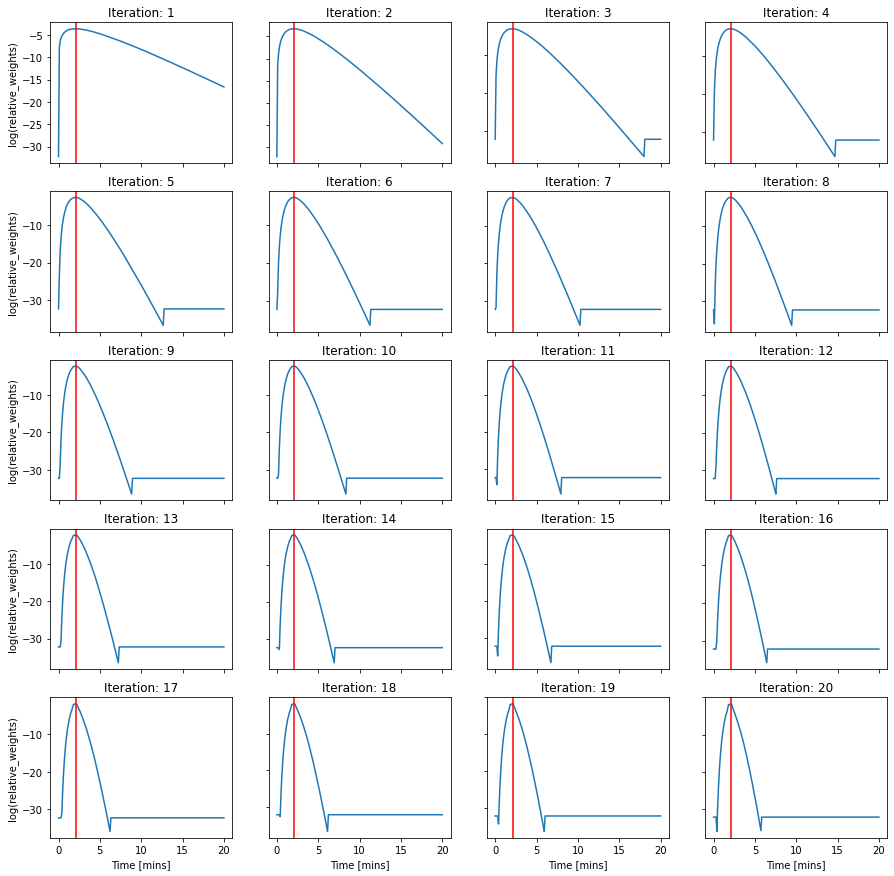

In [125]:
#Plot numerically computated weights
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(nu_weights[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(nu_weights[-1,:]==np.max(nu_weights[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")